In [2]:
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from scipy.interpolate import BSpline
from scipy.interpolate import splrep
from scipy.stats import binned_statistic
from scipy import stats
fig_size = [15,7]
plt.rcParams["figure.figsize"] = fig_size
%matplotlib notebook

In [3]:
# open using the astropy module
# this one is an NTP 
#hdulist = fits.open('kplr000892667-2009166043257_llc.fits')
# use this one instead - it is a PC
# hdulist = fits.open('../data/kplr000757450-2009166043257_llc.fits')
# using this LC to compare to reference paper
#hdulist = []
#fits_dir = '../006022556'
#for root, dirs, filenames in os.walk(fits_dir):
#    for f in filenames:
#        hdulist.append(fits.open(os.path.join(root,f)))

#lc = []
#time = []
#for hdu in hdulist:
#    lc.extend(hdu[1].data['PDCSAP_FLUX'])
#    time.extend(hdu[1].data['TIME'])
#lc = np.array(lc)
#time = np.array(time)
#print(lc.shape)
#kplr006022556-20160128150956_dvt.fits
hdulist = fits.open("kplr006022556-20160128150956_dvt.fits")
#t = Table.read('../new_data/kplr006022556_q1_q17_dr24_tce_01_dvt_lc.tbl', format='ipac')
#print(t.info())
#field = 'INIT_FLUX_PL'
#print(t[field])
#print(np.isnan(t[field]))
#hdulist = fits.open('../data/kplr000891901-2009131105131_llc.fits')
# gather some basic info on the data
hdulist.info()
# check what our columns are
print(hdulist[1].columns)
#print(hdulist[1].data['LC_INIT'])
# zero in on the corrected flux data
# PDCSAP = lc_data['PDCSAP_FLUX']
PDCSAP = hdulist[1].data['LC_DETREND']
#TIME = lc_data['TIME']
TIME= hdulist[1].data['TIME']
phase = hdulist[1].data['PHASE']
tperiod = hdulist[1].header['TPERIOD']
tdur = hdulist[1].header['TDUR']

print("PHASE: ",phase)
print(phase.shape)
print("TPERIOD", tperiod)
print("TDUR", tdur)

Filename: kplr006022556-20160128150956_dvt.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      56   ()      
  1  TCE_1         1 BinTableHDU    106   71427R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  2  Statistics    1 BinTableHDU    221   71427R x 50C   [D, E, J, E, E, E, E, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   
ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2454833'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E13.6'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'PHASE'; format = 'E'; unit = 'days'; disp = 'E14.7'
    name = 'LC_INIT'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'LC_INIT_ERR'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'LC_WHITE'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'LC_DETREND'; format = 'E'; unit = '

<IPython.core.display.Javascript object>


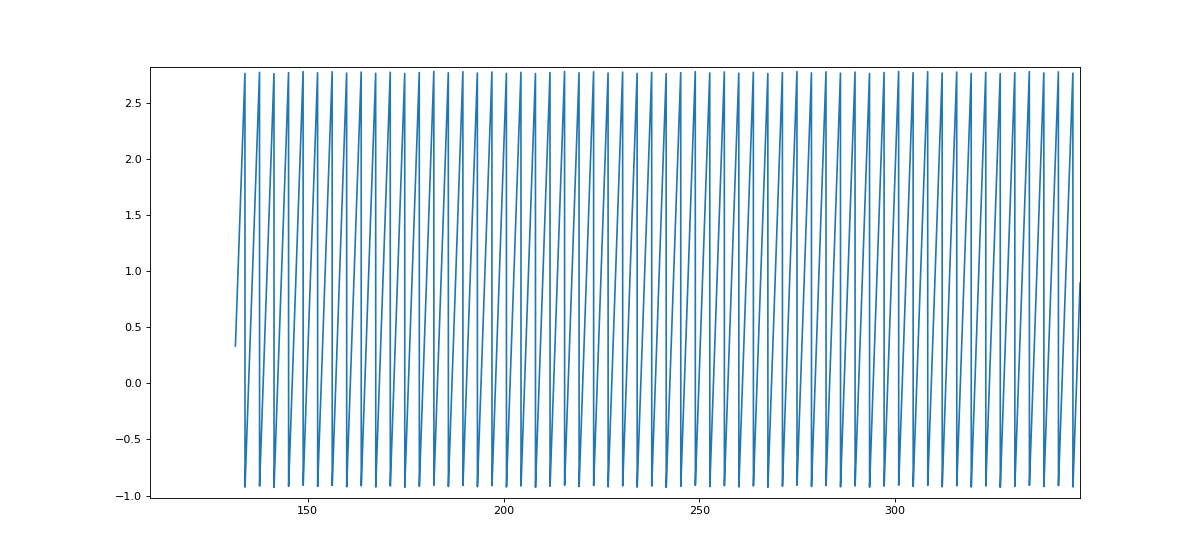

In [46]:
# plot the phases - note that the transit occurs at P=0, which lines up with our other graphs
# and the TPERIOD is the total period between transits
# so we should fold in TPERIOD sized segements, with P=0 in the middle
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(TIME,phase)
plt.show()

In [6]:
# now we need to flatten the light curve to remove low frequency 
# variability

# the way the paper does this is to fit a basis spline to to the LC
# and then divide by the best fit spline

# we want to actually remove the transit events for flattening

x = TIME[~np.isnan(PDCSAP)]
y = PDCSAP[~np.isnan(PDCSAP)]

#x = time[~np.isnan(lc)]
#y = lc[~np.isnan(lc)]

#x = t['TIME'][~np.isnan(t[field])]
#y = t[field][~np.isnan(t[field])]

print(y.shape)
ymin, ymax = y.min(), y.max()
print("Y MIN: ",ymin)
print("Y Max: ",ymax)

(49831,)
Y MIN:  -0.003601079
Y Max:  0.0045871595


In [7]:
# detect all outliers and linearly interpolate

def find_bounds(index, outliers, left=1, right=1):
    if left+index not in outliers and right+index not in outliers:
        return left, right
    if left+index in outliers:
        left += 1
    if right+index in outliers:
        right += 1
    return find_bounds(index, outliers, left, right)

# oh - this works - but the problem is we need to use a sort of running/windowed average and std dev bc
# what we get is actually not catching all the transit points as outliers bc the lc has high variability before
# smoothing

# so we will take bins of our data - and pass those into this

def interpolate_outliers(data, sigma=3):
    new_data = data
    idx = [i for i in range(len(data)) if (abs(data[i] - np.mean(data)) > sigma*np.std(data))]
    # need to be recursive here - if index i is an outlier, but so is the previous one - then extend one that way by one and repeat as needed
    for i in idx:
        left_offset, right_offset = find_bounds(i, idx)
        print("replacing index: ",i, "offset: -",left_offset," ",right_offset)
        data[i] = data[i-left_offset] + (data[i+right_offset]-data[i-left_offset])
    return new_dataLC_INIT

#y = interpolate_outliers(y)


Y MIN:  -0.003601079
Y Max:  0.0045871595
X MIN:  131.51293559967598
X Max:  1557.9595094220567


<IPython.core.display.Javascript object>


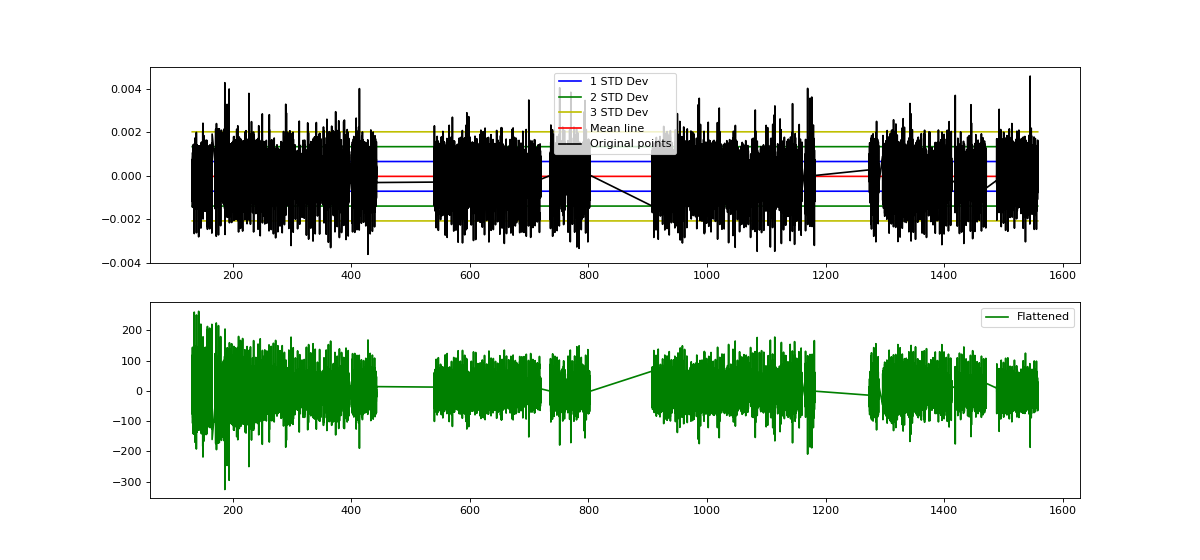

In [45]:
#calc_s = 0.05 * len(y) * np.nanvar(y)
calc_s = len(y) - math.sqrt(2*len(y))
#(m-sqrt(2*m),m+sqrt(2*m))
t,c,k = splrep(x, y, s=calc_s, k=3)
#print('''\
#        t:{}
#        c:{}
#        k:{}
#'''.format(t,c,k))
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
print("Y MIN: ",ymin)
print("Y Max: ",ymax)
print("X MIN: ",xmin)
print("X Max: ",xmax)

xx = np.linspace(xmin, xmax, len(x))
spline = BSpline(t,c,k,extrapolate=False)
# calc mean and std dev
y_mean = [np.nanmean(y)]*len(x)
y_stddev = np.nanstd(y)

fig2 = plt.figure()
ax2 = fig2.add_subplot(211)


# plot the mean and variance lines
ax2.plot(x,y_mean+y_stddev, 'b-',label='1 STD Dev')
ax2.plot(x,y_mean+2*y_stddev, 'g-',label='2 STD Dev')
ax2.plot(x,y_mean+3*y_stddev, 'y-',label='3 STD Dev')
ax2.plot(x,y_mean-y_stddev, 'b-')
ax2.plot(x,y_mean-2*y_stddev, 'g-')
ax2.plot(x,y_mean-3*y_stddev, 'y-')
ax2.plot(xx,y_mean,'r-',label="Mean line")


# plot the original points
ax2.plot(x, y, 'k', label='Original points')

# plot the spline
#plt.plot(xx,spline(xx), 'c', label='BSpline')
ax2.legend(loc='best')

#try a divide
flattened = np.divide(y, spline(x))

# plot the resulting spline
ax3 = fig2.add_subplot(212)
ax3.plot(x, flattened, 'g', label='Flattened')
#plt.grid()
ax3.legend(loc='best')

# try fitting and dividing again
#calc_s_flat = len(flattened) + math.sqrt(2*len(flattened))
#print(calc_s_flat)
#t2,c2,k2 = splrep(x, flattened, s=calc_s_flat, k=3)
#print('''\
#        t:{}
#        c:{}
#        k:{}
#'''.format(t2,c2,k2))
#xx2 = np.linspace(xmin, xmax, len(x))
#spline2 = BSpline(t2,c2,k2,extrapolate=False)
#plt.plot(xx2,spline2(xx2), 'c', label='BSpline2')
ax3.legend(loc='best')
plt.show()

In [9]:
'''x
y
bin_means, bin_edges, binnumber = stats.binned_statistic(x,y, statistic='median', bins=20)
plt.figure()
#plt.plot(x, y, 'b.', label='raw data')

plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=5,
           label='binned statistic of data')
plt.legend()
bin_edges'''


"x\ny\nbin_means, bin_edges, binnumber = stats.binned_statistic(x,y, statistic='median', bins=20)\nplt.figure()\n#plt.plot(x, y, 'b.', label='raw data')\n\nplt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=5,\n           label='binned statistic of data')\nplt.legend()\nbin_edges"

<IPython.core.display.Javascript object>


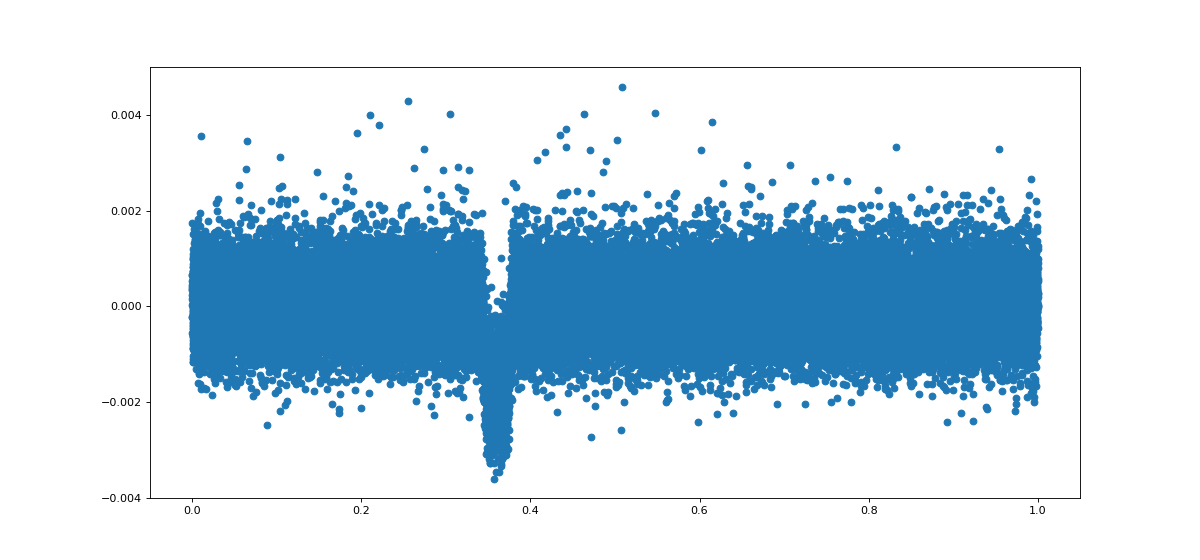

In [48]:
# ok then what needs to happen is this needs to be binned to the period and folded on itself, centered on the TCE


# fold
folds = x / tperiod   # divide by period to convert to phase
folds = folds % 1   # take fractional part of phase only (i.e. discard whole number part)

# plot folded lightcurve
fig3 = plt.figure()
ax4 = fig3.add_subplot(111)
ax4.plot(folds,y,linestyle='none',marker='o')  
plt.show()

0.001854006288028043
0.001854006288028043
NBINS:  26877470.87039344
(49831,)
(49831,)
[0.00045334        nan        nan ...        nan        nan 0.00081202]


<IPython.core.display.Javascript object>


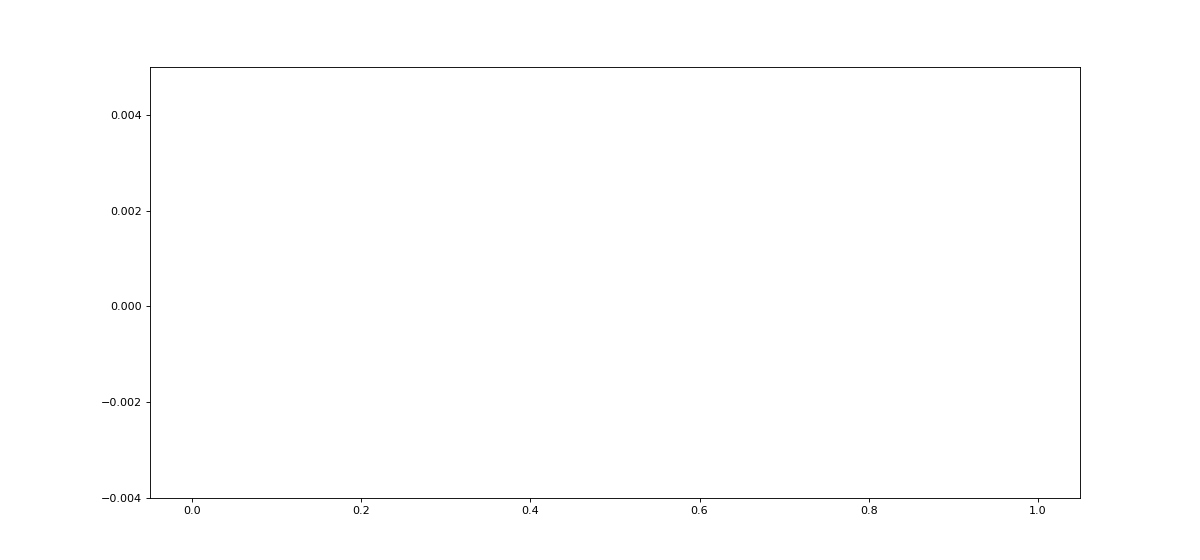

In [67]:
# with delta = lambda, the bins partition the LC
# with delta > lambda the bins overlap and help reduce scatter and show cleaner transits
lmbda = tperiod/2001 # lambda is the distance between midpoints and should be a fraction of either t-period or t-duration
dlta = lmbda # delta is the width of our bins
print(lmbda)
print(dlta)

nbins = len(folds)/lmbda
# apparently this leads to nothing showing in the bins?
#nbins = 1000
print("NBINS: ",nbins)
print(folds.shape)
print(y.shape)
# ok - this works in the simple case, but we need to handle varying levels of lambda and delta to 
# dynamically set the bins - to do so, create the bin edges 
bin_medians, bin_edges, bin_no = binned_statistic(folds, y, statistic='median', bins=nbins, range=None)
print(bin_medians)
# for each bin - get the median value and plot that
fig4 = plt.figure()
ax5 = fig4.add_subplot(111)
ax5.hlines(bin_medians, bin_edges[:-1], bin_edges[1:], colors='g', lw=5, label='binned statistic of data')

plt.show()

In [56]:
## GLOBAL VIEW binning and folding
# take width of bin as fraction of TCE PERIOD

# with delta = lambda, the bins partition the LC

# with delta > lambda the bins overlap and help reduce scatter and show cleaner transits
lmbda = tperiod*.5  # lambda is the distance between midpoints and should be a fraction of either t-period or t-duration
dlta = 1.05*lmbda # delta is the width of our bins
print(lmbda)
print(dlta)

nbins = len(folds)/lmbda
print(nbins)

# ok - this works in the simple case, but we need to handle varying levels of lambda and delta to 
# dynamically set the bins - to do so, we should take the bins as given and add some value to the right side??


1.854933291172057
1.94767995573066
26864.038850967958


In [60]:
## LOCAL VIEW binning and folding
# take width of bin as fraction of TCE DURATION and consider k TCE DURATIONS either side of event


# with delta = lambda, the bins partition the LC
# with delta > lambda the bins overlap and help reduce scatter and show cleaner transits
lmbda = tdur*.5  # lambda is the distance between midpoints and should be a fraction of either t-period or t-duration
dlta = 1.05*lmbda # delta is the width of our bins
print(lmbda)
print(dlta)

nbins = len(folds)/lmbda
print(nbins)

# ok - this works in the simple case, but we need to handle varying levels of lambda and delta to 
# dynamically set the bins - to do so, we should take the bins as given and add some value to the right side??


1.5796590486690714
1.658642001102525
31545.414842515984


From the paper:
 
"We used a global view of length 2001 with λ = δ =
p/2001 (where p is the TCE period), and a local view of
length 201 with k = 4 transit durations on either size of
the event, λ = 2kd/201, and δ = 0.16d (where d is the
TCE duration). See Section 3.3 for a description of these
parameters."
